In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
import seaborn as sns
import json
from scipy import stats

# Configuración visual para los gráficos
plt.style.use('https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-light.mplstyle')
plt.rcParams['figure.figsize'] = (15, 6)

print("Librerías cargadas correctamente.")

Librerías cargadas correctamente.


In [27]:
name_file = 'membresia_ecobici_hsbc'
anio_ = 2026 
# 1. Cargar el dataset
# Asegúrate de que el archivo esté en la misma carpeta o coloca la ruta completa
nombre_archivo = f'../data/data_forecast_{anio_}/data_forecast_{anio_}_raw/ingresos_{name_file}.csv'
print(f"Cargando el archivo: {nombre_archivo}")  # <--- CAMBIA ESTO POR TU ARCHIVO REAL

Cargando el archivo: ../data/data_forecast_2026/data_forecast_2026_raw/ingresos_membresia_ecobici_hsbc.csv


In [28]:

df_main = pd.read_csv(nombre_archivo)

# 2. Conversión de fechas
df_main['fecha'] = pd.to_datetime(df_main['fecha'])

# 3. Verificación rápida
print(f"Rango de fechas: {df_main['fecha'].min()} a {df_main['fecha'].max()}")
print(f"Tipos de suscripción encontrados: {df_main['tipo_suscripcion'].unique()}")
display(df_main.head())

Rango de fechas: 2024-12-20 00:00:00 a 2025-11-30 00:00:00
Tipos de suscripción encontrados: ['Ecobici HSBC']


,anio,mes_numero,dia_numero,dia_semana,tipo_suscripcion,id_suscripcion,cantidad_Vendida,ingresos_totales_reales,fecha
0,2024,12,20,Friday,Ecobici HSBC,10,6,5694.0,2024-12-20
1,2024,12,21,Saturday,Ecobici HSBC,10,3,2847.0,2024-12-21
2,2024,12,22,Sunday,Ecobici HSBC,10,5,4745.0,2024-12-22
3,2024,12,23,Monday,Ecobici HSBC,10,1,949.0,2024-12-23
4,2024,12,24,Tuesday,Ecobici HSBC,10,1,949.0,2024-12-24


In [29]:
# eliminar columnas innecesarias si existen
columnas_a_eliminar = ['anio', 'mes_numero', 'dia_numero', 'dia_semana', 'tipo_suscripcion', 'id_suscripcion']  # Reemplaza con nombres reales
df_main = df_main.drop(columns=[col for col in columnas_a_eliminar if col in df_main.columns])
print("Columnas innecesarias eliminadas.")
df_main.head()

Columnas innecesarias eliminadas.


,cantidad_Vendida,ingresos_totales_reales,fecha
0,6,5694.0,2024-12-20
1,3,2847.0,2024-12-21
2,5,4745.0,2024-12-22
3,1,949.0,2024-12-23
4,1,949.0,2024-12-24


### Deteccion de ouliers

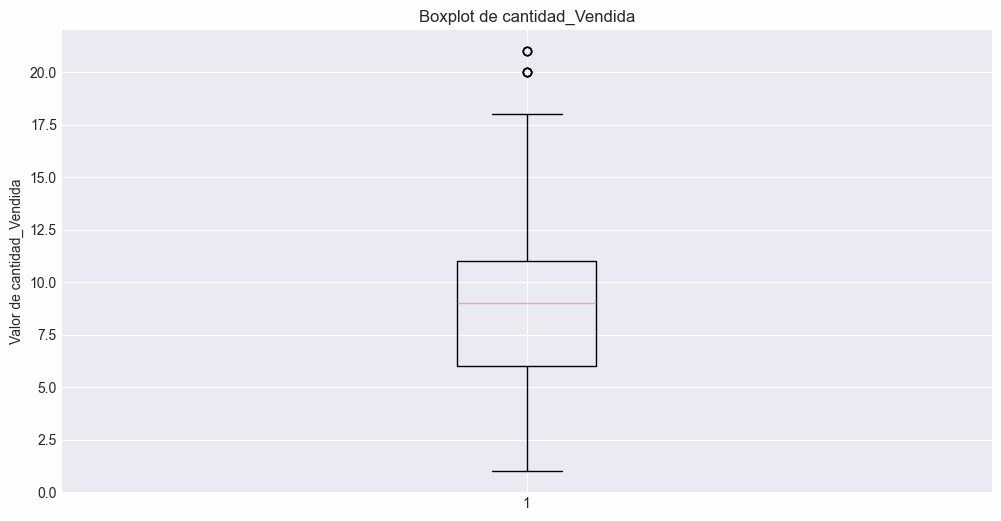

In [30]:
plt.figure(figsize=(12, 6))
plt.boxplot(df_main['cantidad_Vendida'])
plt.title('Boxplot de cantidad_Vendida')
plt.ylabel('Valor de cantidad_Vendida')
plt.show()

In [31]:
# Calculando la mediana de los datos no extremos como valor de imputación
mediana = df_main['cantidad_Vendida'].median()

# Calculando el IQR para identificar outliers
Q1 = df_main['cantidad_Vendida'].quantile(0.25)
Q3 = df_main['cantidad_Vendida'].quantile(0.75)
IQR = Q3 - Q1

# Definiendo los límites para identificar outliers
lower_limit = Q1 - 1.5 * IQR
upper_limit = Q3 + 1.5 * IQR

# Imputando outliers con la mediana
df_main['cantidad_Vendida_imputado'] = np.where(
    (df_main['cantidad_Vendida'] < lower_limit) | (df_main['cantidad_Vendida'] > upper_limit),
    mediana,  # Valor de imputación
    df_main['cantidad_Vendida']  # Mantener el valor original si no es un outlier
)

In [32]:
# Mostrando el efecto de la imputación
print("Valores originales (con outliers):")
# print(df_main['ingresos_totales_reales'].describe())
df_main['cantidad_Vendida'].describe()

Valores originales (con outliers):


count    323.000000
mean       8.978328
std        3.893317
min        1.000000
25%        6.000000
50%        9.000000
75%       11.000000
max       21.000000
Name: cantidad_Vendida, dtype: float64

In [33]:
print("\nValores después de la imputación de outliers:")
print(df_main['cantidad_Vendida_imputado'].describe())


Valores después de la imputación de outliers:
count    323.000000
mean       8.730650
std        3.498698
min        1.000000
25%        6.000000
50%        9.000000
75%       11.000000
max       18.000000
Name: cantidad_Vendida_imputado, dtype: float64


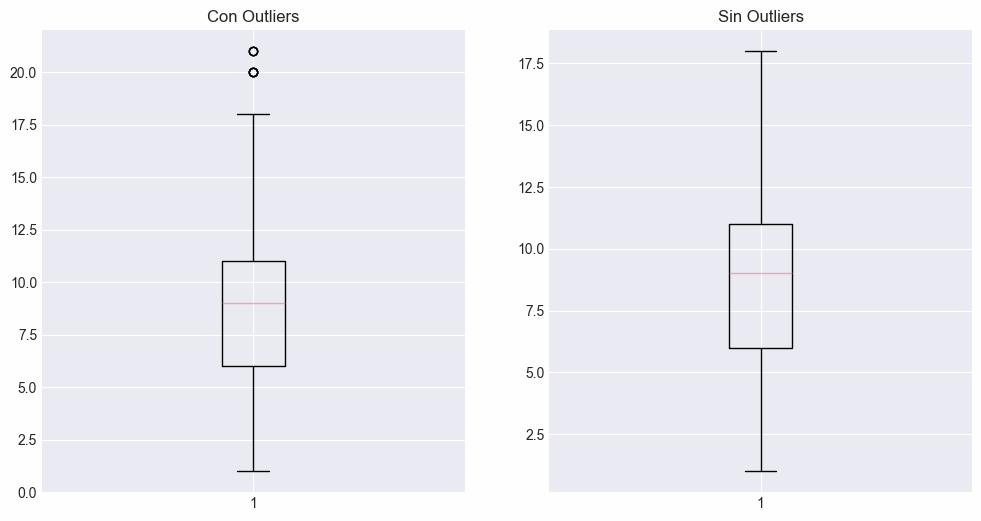

In [34]:
# Visualización de los datos con y sin outliers usando boxplot
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.boxplot(df_main['cantidad_Vendida'])
plt.title('Con Outliers')

plt.subplot(1, 2, 2)
plt.boxplot(df_main['cantidad_Vendida_imputado'])
plt.title('Sin Outliers')

plt.show()

In [35]:
df_main.describe()

,cantidad_Vendida,ingresos_totales_reales,fecha,cantidad_Vendida_imputado
count,323.000000,323.000000,323,323.000000
mean,8.978328,8139.763034,2025-06-21 10:19:41.424148480,8.730650
min,1.000000,949.000000,2024-12-20 00:00:00,1.000000
25%,6.000000,5551.640000,2025-04-02 12:00:00,6.000000
50%,9.000000,7686.840000,2025-06-22 00:00:00,9.000000
75%,11.000000,10083.100000,2025-09-10 12:00:00,11.000000
max,21.000000,19501.920000,2025-11-30 00:00:00,18.000000
std,3.893317,3535.380550,NaN,3.498698


In [36]:
ruta = f'../data/data_forecast_{anio_}/data_forecast_{anio_}_silver/numero_{name_file}_limpio.csv'
print(f"Guardando el dataset limpio en: {ruta}")

df_main.to_csv(ruta, index=False)
print(f"Dataset limpio guardado como 'numero_{name_file}_limpio.csv'.")

Guardando el dataset limpio en: ../data/data_forecast_2026/data_forecast_2026_silver/numero_membresia_ecobici_hsbc_limpio.csv
Dataset limpio guardado como 'numero_membresia_ecobici_hsbc_limpio.csv'.
